In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
if 'imNum' not in dir():
    imNum = 1   # счётчик для названий картинок
impath = 'trash_img'    # путь к папке, в которой будут сохраняться картинки
#switching latex fonts
plt.rcParams.update({
    "text.usetex" : True,
    "font.family" : "serif",
    "font.serif" : "Computer Modern",
    "text.latex.preamble" : r'\usepackage{amsmath} \usepackage{mathtext} \usepackage[english, russian]{babel}'
})
plt.rcParams.update({
    "figure.figsize": (8, 6),
    'figure.dpi': 200
})

# необходимые функции

def err_pres_formatter(value, error):
    """Rounds value and it's error according to scientific conventions"""
    first_digit = (np.array(error/10**np.floor(np.log10(error)), dtype="int"))
    first_digit_position = np.array(np.floor(np.log10(error)), dtype="int")
    ndigits = 1
    if first_digit == 1:
        ndigits += 1
    power = np.log10(abs(value))
    if abs(power//3) >= 1:
        power = 3*int(power//3)
        value /= 10**power
        error /= 10**power
        digit_number = -first_digit_position + ndigits+power-1
        if digit_number <= 0:
            return f"({round(int(value), digit_number)} \u00B1 {round(int(error), digit_number)})$\cdot 10^{{{power}}}$"
        return f"({round(value, digit_number)} \u00B1 {round(error, digit_number)})$\cdot 10^{{{power}}}$"
    digit_number = -first_digit_position + ndigits-1
    if digit_number <= 0:
        return f"{round(int(value), digit_number)} \u00B1 {round(int(error), digit_number)}"
    return f"{round(value, digit_number)} \u00B1 {round(error, digit_number)}"


def lower_upper_limits(domain, fun, popt, pcov, nsigma=1):
    '''Вычисляет минимальные и максимальные значения функции 
    при заданных парамерах и стандартных отклонениях
    в пределах nsigma*стандартное отклонение
    Возвращает:
    minA :(np.array) - массив минимальных значений
    maxA :(np.array) - массив максимальных значений'''
    err = np.sqrt(np.diag(pcov))
    corr = pcov /np.expand_dims(err, 1) / np.expand_dims(err, 0)
    deviations = np.eye(popt.size)*np.expand_dims(err, 1)  
    df = np.expand_dims(fun(domain, *popt), 1) - fun(np.expand_dims(domain, 1), *(np.expand_dims(popt, 1)+np.eye(popt.size)*np.expand_dims(err, 1)))
    dfmatrixes = np.expand_dims(df, 1)*np.expand_dims(df, 2) * np.expand_dims(corr, 0)
    sigm_f = np.sqrt(np.sum(dfmatrixes, axis=(1, 2)))
    return (fun(domain, *popt)-nsigma*sigm_f, fun(domain, *popt)+nsigma*sigm_f)

def plot_approx(x, y, f, par_names_str, fun_name, yerr=None, visApproxError=True, p0=None):
    if yerr is not None:
        popt, pcov = curve_fit(f, x, y, sigma=yerr, absolute_sigma=True, p0=p0)
    else:
        popt, pcov = curve_fit(f, x, y, p0=p0)
    err = np.sqrt(np.diag(pcov))
    for v, er in zip(popt, err):
        print(v,'+-',er)
    approx_label = f"аппроксимация функцией {fun_name}"
    if (err == np.inf).any():
        print('Аппроксимация не сошлась. Попробуй задать начальные параметры p0')
    else:
        par_names = [x.split(',') for x in par_names_str.strip().split("\n") if (len(x) != 0)]
        for i in range(len(par_names)):
            t = par_names[i]
            if len(t) == 2:
                name, units = t
            else:
                name, units = *t, ''
            approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])} {units}"
    teorPoints = 50     
    intent = 0.05   # отступ по бокам от обласи экспериментальных данных
    a, b = x.min(), x.max()
    X = np.linspace(a-(b-a)*intent, b+(b-a)*intent, num=teorPoints)
    plt.plot(X, f(X, *popt), 'r', label=approx_label)
    if visApproxError and (pcov != np.inf).all():
        nsigma = 2
        minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)
        plt.fill_between(X, minA, maxA, alpha=0.4, label=f"область {nsigma} $\sigma$ ошибки")

def make_beautiful_plot(xname, xunit, yname, yunit):
    plt.grid(True, which='minor', linewidth=0.2)
    plt.grid(True, which='major')
    plt.xlabel(fr"{xname}, {xunit}")
    plt.ylabel(fr"{yname}, {yunit}")
    plt.title(fr"{yname}({xname})")
    plt.legend()

In [18]:
#ВВод данных
df = pd.read_excel("measurements.ods", engine="odf", sheet_name=0) # для таблиц ods (требуется установка pip install odfpy)
# df = pd.read_excel("measurements.xls")    # excel таблицы
dx = df.iloc[:, 0].dropna() 
R = df.iloc[:, 1].dropna()

I = 1.38/2000/(560+R)
x = dx
y = I
# xerr = np.ones_like(x)*0.01
# yerr = np.ones_like(x)*0.01
xerr = None
yerr = None
df.head()

,"x, см","R, Ом",Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,N,"x, см.1","x, см.2"
0,24.60,1500.0,1,1.000000,1500.000000,NaN,1.0,24.1,24.1
1,22.15,1720.0,0.9,1.111111,1722.222222,NaN,2.0,19.2,18.9
2,19.70,2000.0,0.8,1.250000,2000.000000,NaN,3.0,14.9,14.6
3,17.30,2360.0,0.7,1.428571,2357.142857,NaN,4.0,11.8,11.4
4,14.90,2830.0,0.6,1.666667,2833.333333,NaN,5.0,9.1,8.9


In [19]:
# параметры построения графика и аппроксмации прямой
# пользовательские параметры. Переменные x, y, xerr, yerr дожны содержать данные
''' также необходимо изменить
название графика, 
название функции ,
набор параметров с размерностями через запятую '''
visApproxError = False   # рисовать ли область ошибки аппроксимации
hasErrors = True
# visApproxError*=hasErrors   # нельзя рисовать ошибки, если их нет)
xname, xunit = r"$x$", "см"
yname, yunit = r"$I$", "А"
par_names_str = fr'''
k, $\frac{{{yunit}}}{{{xunit}}}$
b, {yunit}
'''
# function to approximate
fun_name = r"$f(x) = kx + b$"
def f(x, k, b):
    return b + k * x
# конец пользовательских параметров

1.3726539048839127e-08 +- 4.5634494718068166e-11
-1.2049879499045197e-09 +- 6.66435746152043e-10


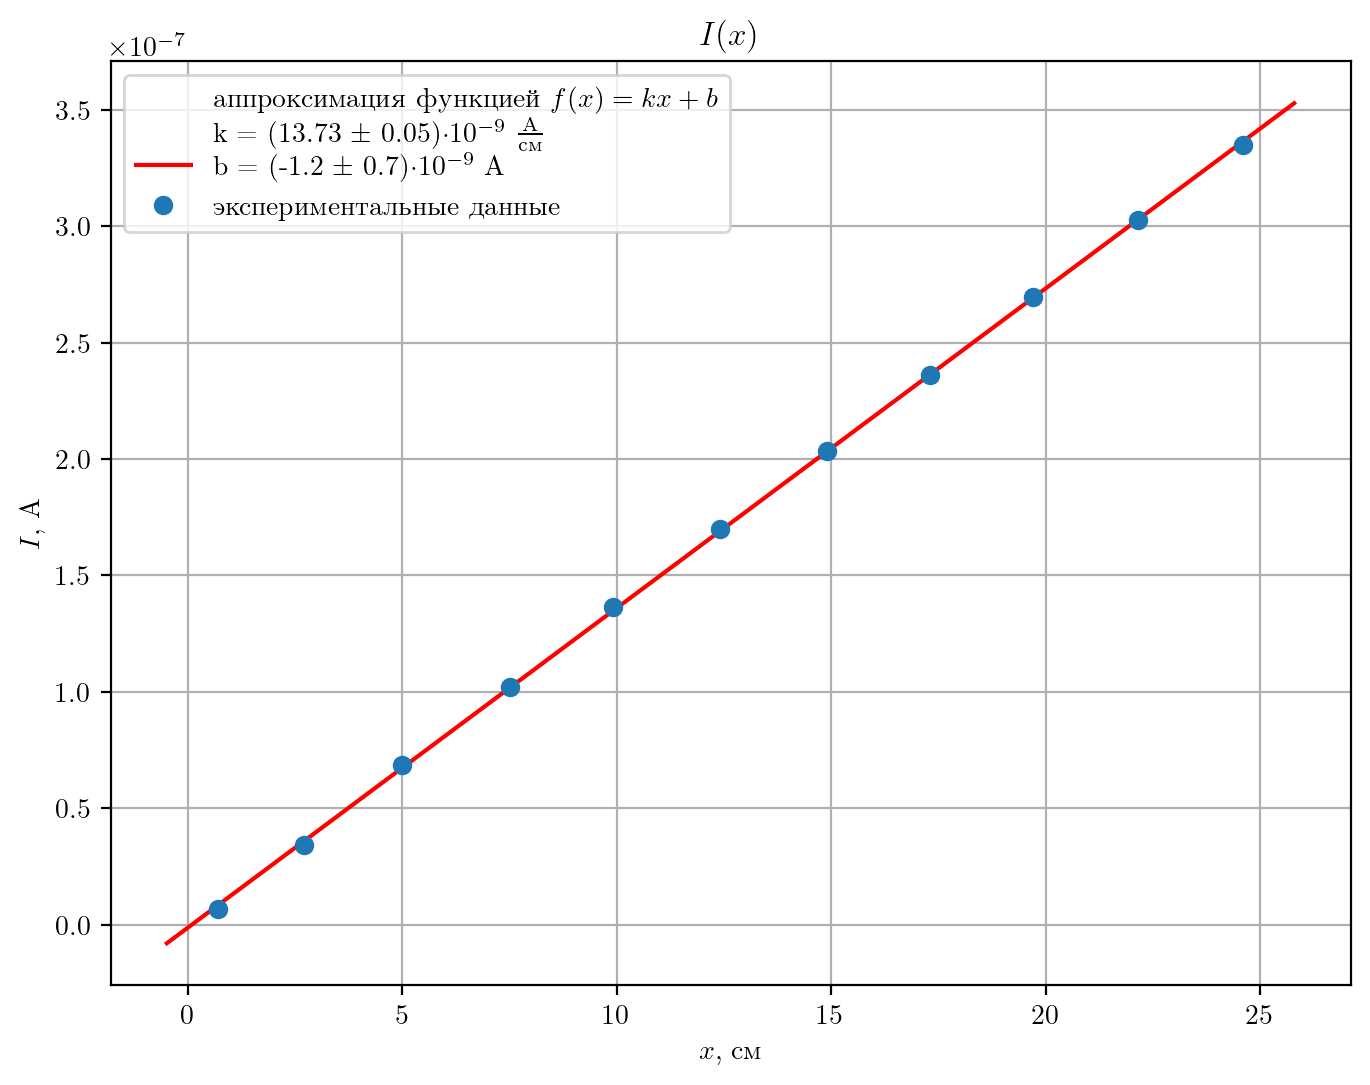

In [20]:
# построение графика

# аппроксимация
plot_approx(x, y, f, par_names_str, fun_name, yerr=yerr, visApproxError=visApproxError)

# экспериментальные точки
plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label="экспериментальные данные", capsize=4, ms=6)

make_beautiful_plot(xname, xunit, yname, yunit)

if not os.path.exists(impath):
    os.makedirs(impath)
plt.savefig(os.path.join(impath, f"templ{imNum}.png"), dpi=300)
imNum+=1

In [7]:
1.3726539048839127e-08 * 200, 4.5634494718068166e-11*200

(2.7453078097678253e-06, 9.126898943613633e-09)

In [8]:
# шаблон аппроксимации экспонентой
# пользовательские параметры. Переменные x, y, xerr, yerr дожны содержать данные
''' также необходимо изменить
название графика, 
название функции,
набор параметров с размерностями через запятую '''
visApproxError = True   # рисовать ли область ошибки аппроксимации
hasErrors = True
# visApproxError*=hasErrors   # нельзя рисовать ошибки, если их нет)
xname, xunit = r"$t$", "с"
yname, yunit = r"$h$", "см"
par_names_str = fr'''
$f_0$, {yunit}
$\Delta f$, {yunit}
$T_0$, {xunit}
'''
# function to approximate
fun_name = r"$f(x) = f_0 + \Delta f e^{-x/T_0}$"
def f(x, f_0, df, T0):
    return f_0 + df*np.exp(-x/T0)
# конец пользовательских параметров
p0 = [y[0], y.max()-y.min(), (x.max()-x.min())/8]   # адекватное начальное приближение параметров

In [9]:
# параметры построения графика и аппроксмации относительно произвольной функцией
# пользовательские параметры. Переменные x, y, xerr, yerr дожны содержать данные
''' также необходимо изменить
название графика,
название функции ,
набор параметров с размерностями через запятую '''
visApproxError = True   # рисовать ли область ошибки аппроксимации
hasErrors = True
# visApproxError*=hasErrors   # нельзя рисовать ошибки, если их нет)
par_names_str = r'''
k,
b,
'''
xname, xunit = r"$x$", ""
yname, yunit = r"$y$", ""
# function to approximate
fun_name = r"$f(x) = kx + b$"
def f(x, k, b):
    return b + k * x
# конец пользовательских параметров

## Затухание

In [10]:
# параметры построения графика и аппроксмации прямой
# пользовательские параметры. Переменные x, y, xerr, yerr дожны содержать данные
''' также необходимо изменить
название графика, 
название функции ,
набор параметров с размерностями через запятую '''
visApproxError = False   # рисовать ли область ошибки аппроксимации
hasErrors = True
# visApproxError*=hasErrors   # нельзя рисовать ошибки, если их нет)
xname, xunit = r"$x$", ""
yname, yunit = r"$y$", ""
par_names_str = fr'''
k, $\frac{{{yunit}}}{{{xunit}}}$
b, {yunit}
'''
# function to approximate
fun_name = r"$f(x) = kx + b$"
def f(x, k, b):
    return b + k * x
# конец пользовательских параметров

-0.24223262880001362 +- 0.003367816310540843
3.429599137914383 +- 0.009501705644031425
-0.24830789862867186 +- 0.0034255412699993465
3.4310926606494356 +- 0.009569175733074031


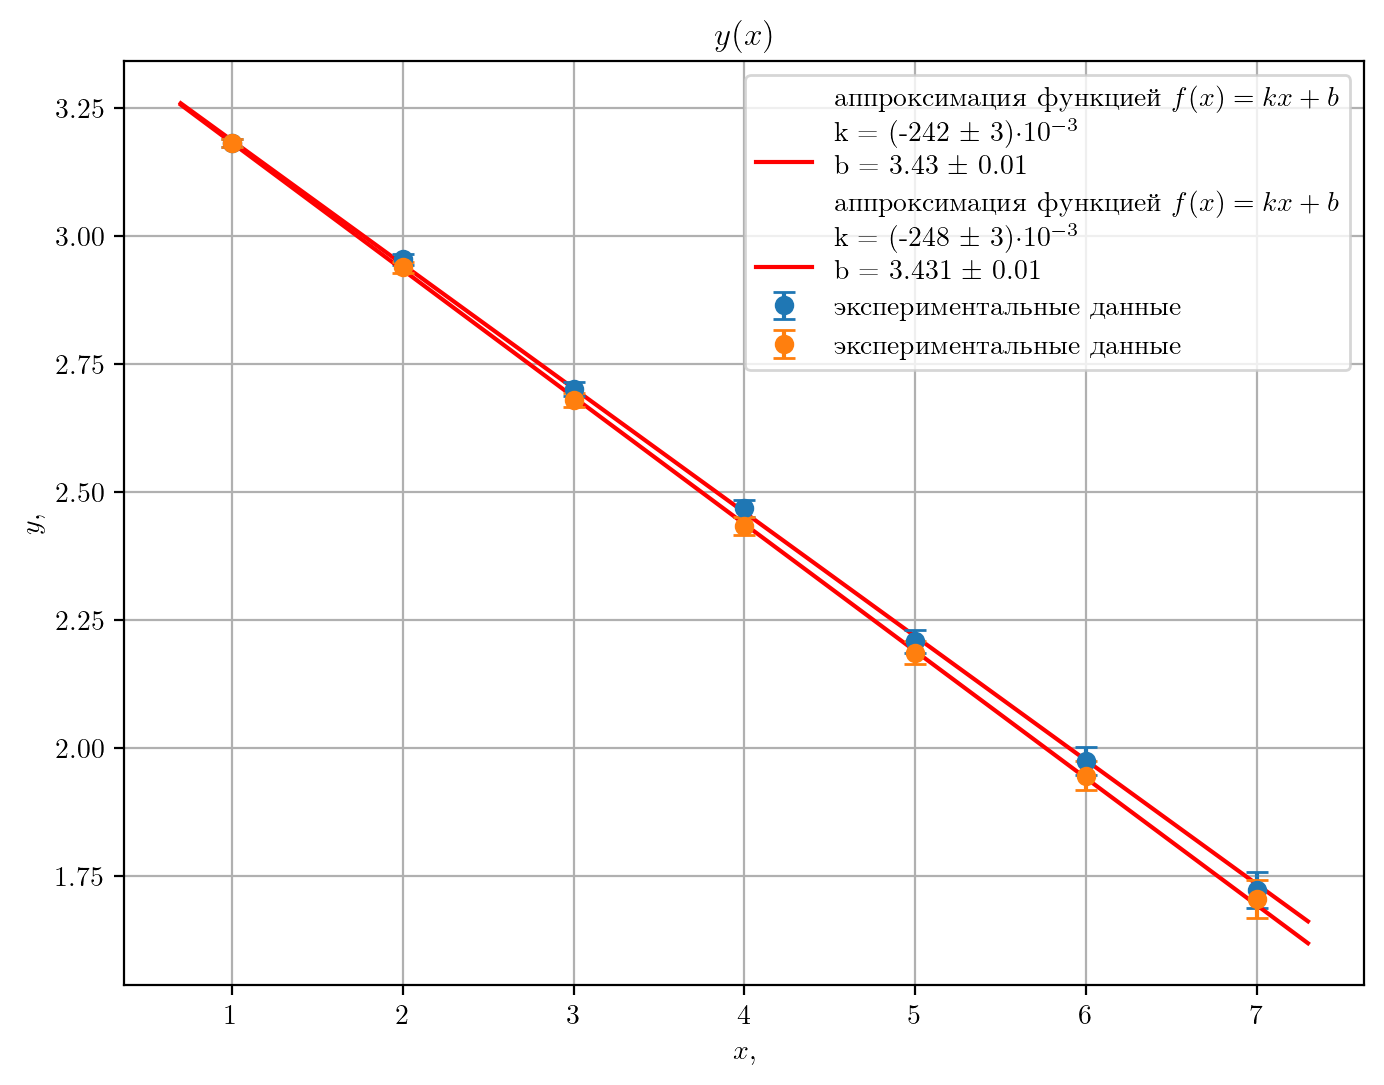

In [11]:
#ВВод данных
df = pd.read_excel("measurements.ods", engine="odf", sheet_name=0) # для таблиц ods (требуется установка pip install odfpy)
# df = pd.read_excel("measurements.xls")    # excel таблицы
x = df.iloc[:, 6].dropna()
y = np.log(df.iloc[:, 7].dropna())
xerr = None
yerr = 0.2/df.iloc[:, 7].dropna()
df.head()
# построение графика

# аппроксимация
plot_approx(x, y, f, par_names_str, fun_name, yerr=yerr, visApproxError=visApproxError)

# экспериментальные точки
plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label="экспериментальные данные", capsize=4, ms=6)

x = df.iloc[:, 6].dropna()
y = np.log(df.iloc[:, 8].dropna())
xerr = None
yerr = 0.2/df.iloc[:, 8].dropna()
df.head()
# построение графика

# аппроксимация
plot_approx(x, y, f, par_names_str, fun_name, yerr=yerr, visApproxError=visApproxError)

# экспериментальные точки
plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label="экспериментальные данные", capsize=4, ms=6)




make_beautiful_plot(xname, xunit, yname, yunit)

if not os.path.exists(impath):
    os.makedirs(impath)
plt.savefig(os.path.join(impath, f"templ{imNum}.png"), dpi=300)
imNum+=1

### критическое R


In [59]:
#ВВод данных
df = pd.read_excel("measurements.ods", engine="odf", sheet_name=1) # для таблиц ods (требуется установка pip install odfpy)
# df = pd.read_excel("measurements.xls")    # excel таблицы
O = df.iloc[:, 6].dropna()
R = df.iloc[:, 8].dropna()
y = 1/O**2
x = (R+560)**2
l_2 = df.iloc[:, 4].dropna()
do = 0.2/l_2
yerr = do/O**3
xerr = None
df.head(n=10)

,"X_1, см","X_2, см",d,"X_1, см.1","X_2, см.1",d.1,d_ср,k,R,Unnamed: 9,R1/R2
0,15.5,2.3,0.828604,15.5,2.4,0.810120,0.819362,3,28200,NaN,1/500
1,20.5,4.5,0.658541,20.5,4.5,0.658541,0.658541,4,37600,NaN,1/200
2,16.4,4.7,0.542746,16.4,4.8,0.533603,0.538174,5,47000,NaN,1/200
3,13.7,4.8,0.455479,13.7,4.8,0.455479,0.455479,6,56400,NaN,1/200
4,21.4,9.0,0.376171,21.4,9.0,0.376171,0.376171,8,75200,NaN,1/100
5,17.0,8.2,0.316635,17.0,8.2,0.316635,0.316635,10,94000,NaN,NaN


In [57]:
do

0    0.041667
1    0.022222
2    0.020833
3    0.020833
4    0.011111
5    0.012195
Name: X_2, см.1, dtype: float64

In [60]:
# параметры построения графика и аппроксмации прямой
# пользовательские параметры. Переменные x, y, xerr, yerr дожны содержать данные
''' также необходимо изменить
название графика, 
название функции ,
набор параметров с размерностями через запятую '''
visApproxError = False   # рисовать ли область ошибки аппроксимации
hasErrors = True
# visApproxError*=hasErrors   # нельзя рисовать ошибки, если их нет)
xname, xunit = r"$(R+R_0)^2$", r"$Ом^2$"
yname, yunit = r"$\frac{1}{\theta^2}$", ""
par_names_str = fr'''
k, $\frac{{{1}}}{{{xunit.replace('$', '')}}}$
b, {yunit}
'''
# function to approximate
fun_name = r"$f(x) = kx + b$"
def f(x, k, b):
    return b + k * x
# конец пользовательских параметров

1.3705729494528705e-09 +- 1.5373192543366752e-10
0.33809603351224454 +- 0.23504130740679385


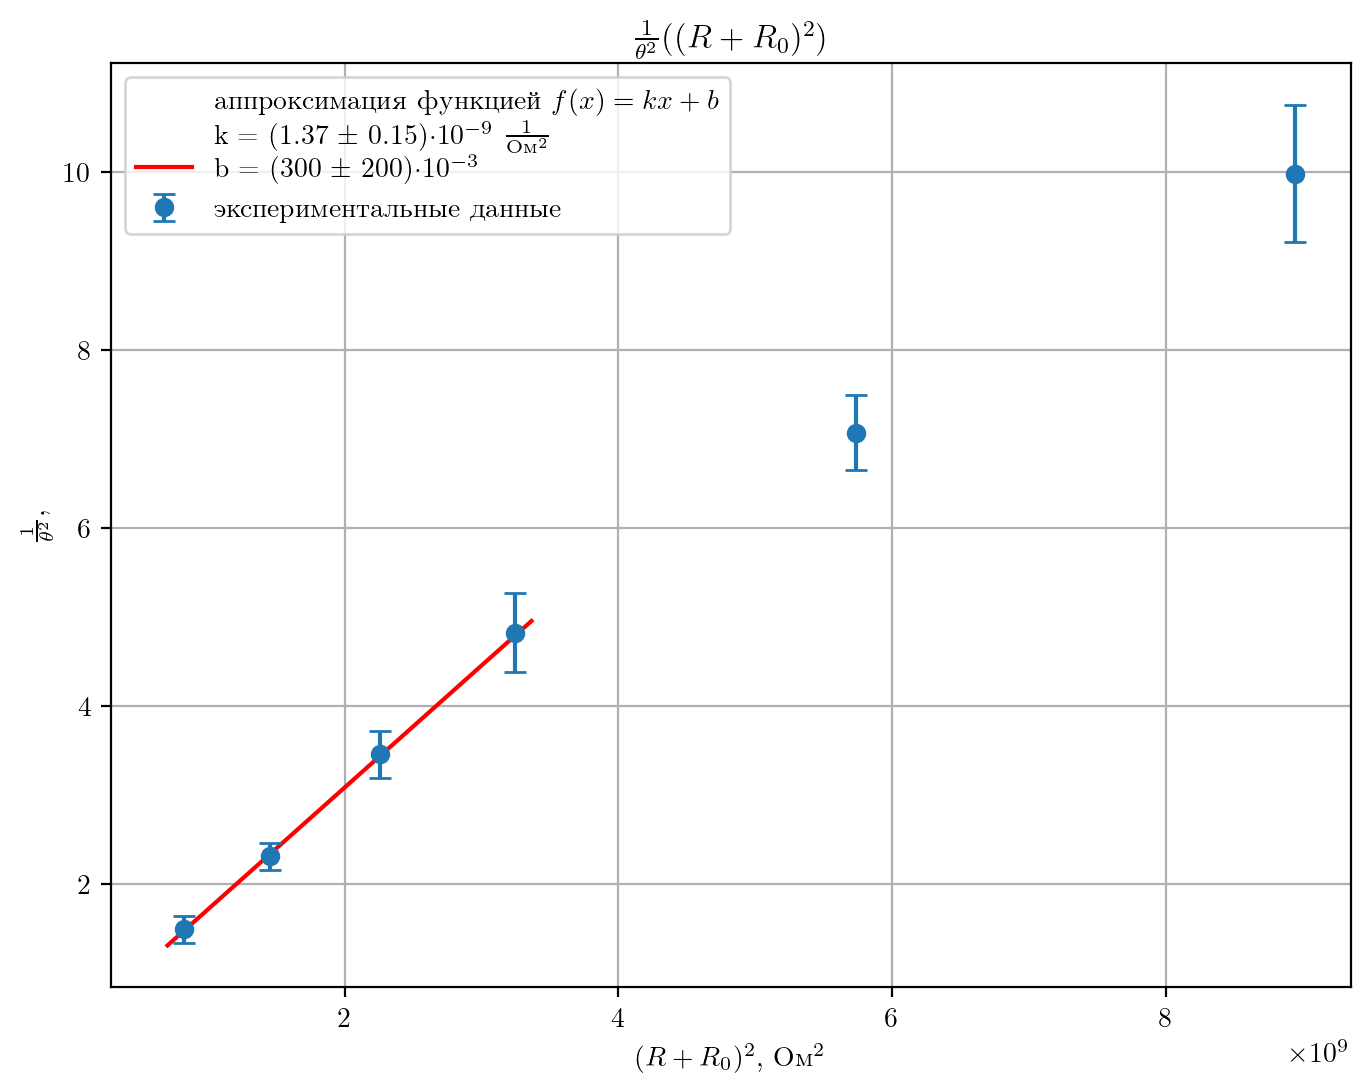

In [61]:
# построение графика

# аппроксимация
filter = x < 4e9
plot_approx(x[filter], y[filter], f, par_names_str, fun_name, yerr=yerr[filter], visApproxError=visApproxError)

# экспериментальные точки
plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label="экспериментальные данные", capsize=4, ms=6)

make_beautiful_plot(xname, xunit, yname, yunit)

if not os.path.exists(impath):
    os.makedirs(impath)
plt.savefig(os.path.join(impath, f"templ{imNum}.png"), dpi=300)
imNum+=1

In [30]:
1/2/np.pi*np.sqrt(1/1.3840625747191354e-09) - 560

3718.0146644150536

## Балистический метод

In [31]:
#ВВод данных
df = pd.read_excel("measurements.ods", engine="odf", sheet_name=2) # для таблиц ods (требуется установка pip install odfpy)
# df = pd.read_excel("measurements.xls")    # excel таблицы
y = df.iloc[:, 0].dropna()
x = df.iloc[:, 2].dropna()
xerr = None
yerr = np.ones_like(x)*0.1
df.head()

,"l, см",R,1/(R+R_0),Unnamed: 3,Unnamed: 4
0,19.9,NaN,0.000000,NaN,7.37037
1,16.4,50000.0,0.000020,NaN,NaN
2,14.9,30000.0,0.000033,NaN,NaN
3,10.6,10000.0,0.000095,NaN,NaN
4,8.0,6000.0,0.000152,NaN,NaN


In [32]:
# параметры построения графика и аппроксмации прямой
# пользовательские параметры. Переменные x, y, xerr, yerr дожны содержать данные
''' также необходимо изменить
название графика, 
название функции ,
набор параметров с размерностями через запятую '''
visApproxError = False   # рисовать ли область ошибки аппроксимации
hasErrors = True
# visApproxError*=hasErrors   # нельзя рисовать ошибки, если их нет)
xname, xunit = r"$\frac{1}{R+R_0}$", r"$\frac{1}{Ом}$"
yname, yunit = r"$l_{max}$", "см"
par_names_str = fr'''
k, ${{yunit}} Ом$
b, {yunit}
'''
# function to approximate
fun_name = r"$f(x) = kx + b$"
def f(x, k, b):
    return b + k * x
# конец пользовательских параметров

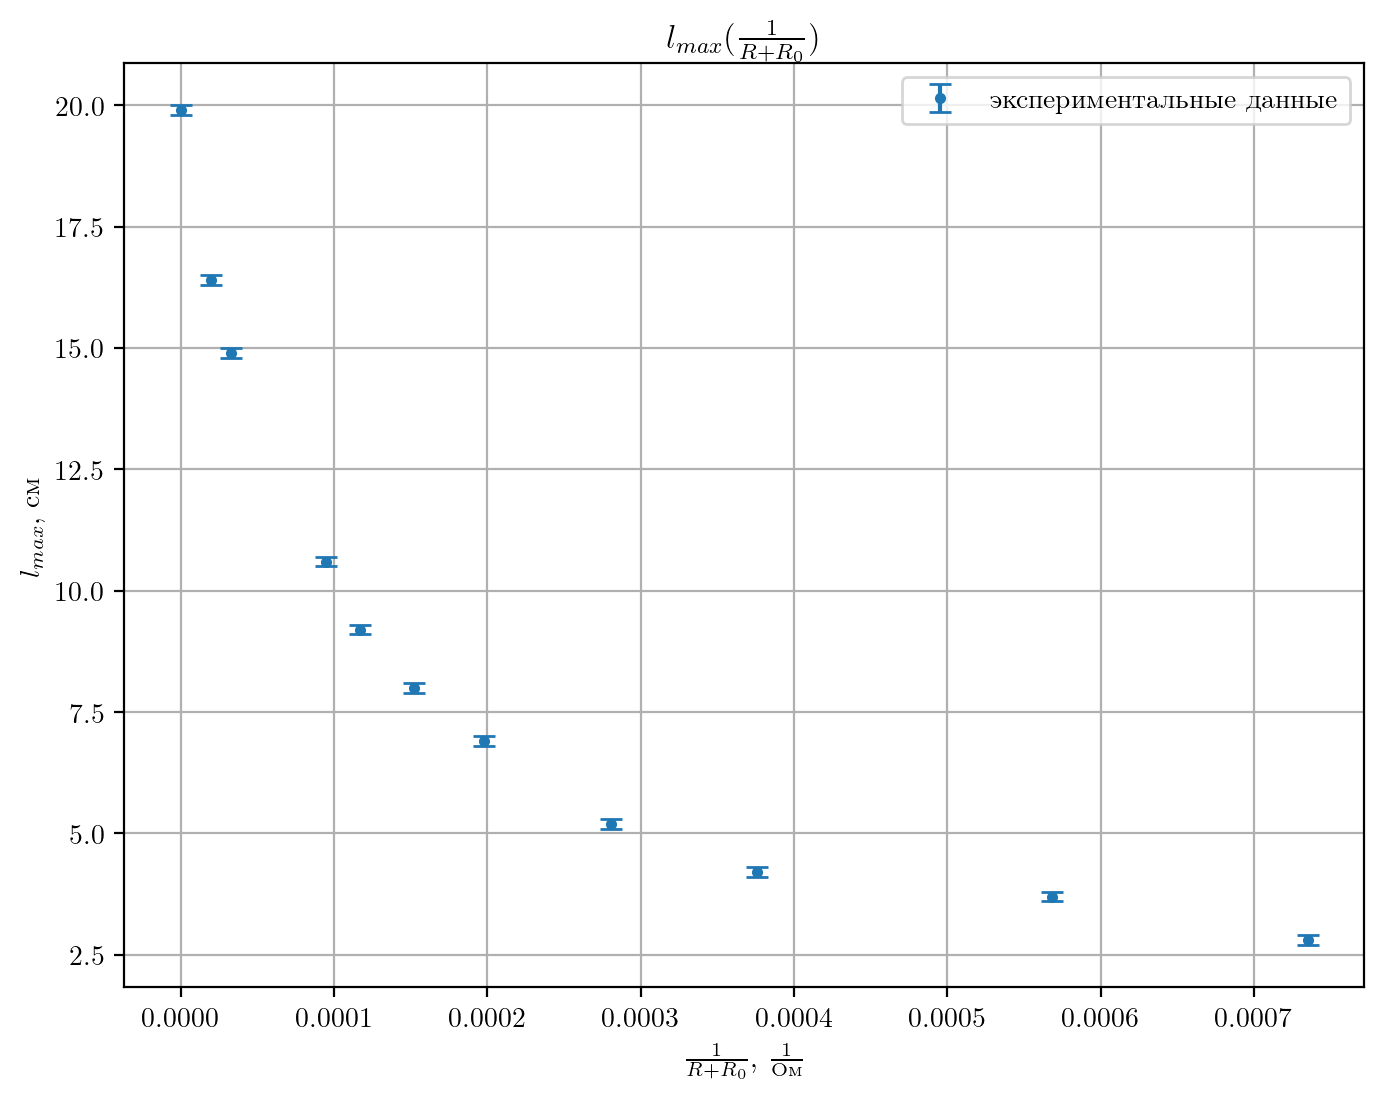

In [35]:
# построение графика

# аппроксимация
# plot_approx(x, y, f, par_names_str, fun_name, yerr=yerr, visApproxError=visApproxError)

# экспериментальные точки
plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label="экспериментальные данные", capsize=4, ms=3)

make_beautiful_plot(xname, xunit, yname, yunit)

if not os.path.exists(impath):
    os.makedirs(impath)
plt.savefig(os.path.join(impath, f"templ{imNum}.png"), dpi=300)
imNum+=1

# Блоки для добавления в ячейку построения графика

In [15]:
# выбор поднабора для построения на графике и аппроксимации
filter = x < 15000
x = x[filter]
y = y[filter]
xerr = xerr[filter]
yerr = yerr[filter]

TypeError: 'NoneType' object is not subscriptable

In [ ]:
# опциональная загрузка данных разных измерений
N = 0 # номер измерения
stride = 3
x = df.iloc[:, stride*N+1].dropna()
y = df.iloc[:, stride*N+0].dropna()
xerr = np.ones_like(x)*0.1
yerr = np.ones_like(x)*1
label = df.iloc[:, stride*N+stride-2].name    # если он есть, его надо добавить в label errorbar'а
xname, xunit = x.name.split(', ')
yname, yunit = y.name.split(', ')

In [ ]:
plt.gca().set_xscale('log')